# Multi-Objective Optimization - 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/Multi_objective_optimization_101.ipynb)

In this tutorial, we will explore how to run black-box multi-objective optimization (MOO). In this setting, the goal is to resolve the following problem:

$$ \text{max}_x (f_0(x), f_1(x), ..., f_n(x)) $$

where $x$ is the set of optimized variables and $f_i$ are the different objectives. In DeepHyper, we use scalarization to transform such multi-objective problem into a single-objective problem:

$$ \text{max}_x s_w((f_0(x), f_1(x), ..., f_n(x))) $$

where $w$ is a set of weights which manages the trade-off between objectives and $s_w : \mathbb{R}^n \rightarrow \mathbb{R}$. The weight vector $w$ is randomized and re-sampled for each new batch of suggestion from the optimizer.



We will look at the DTLZ benchmark suite, a classic in multi-objective optimization (MOO) litterature. This benchmark exibit some characteristic cases of MOO. By default, this tutorial is loading the DTLZ-II benchmark which exibit a Pareto-Front with a concave shape.

In [1]:
import os

n_objectives = 2

# Configuration of the DTLZ Benchmark
os.environ["DEEPHYPER_BENCHMARK_DTLZ_PROB"] = str(2)
os.environ["DEEPHYPER_BENCHMARK_NDIMS"] = str(8)
os.environ["DEEPHYPER_BENCHMARK_NOBJS"] = str(n_objectives)
os.environ["DEEPHYPER_BENCHMARK_DTLZ_OFFSET"] = str(0.5)
os.environ["DEEPHYPER_BENCHMARK_FAILURES"] = str(0)

# Loading the DTLZ Benchmark
import deephyper_benchmark as dhb; dhb.load("DTLZ");
from deephyper_benchmark.lib.dtlz import hpo, metrics

We can display the variable search space of the benchmark we just loaded:

In [2]:
hpo.problem

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x6, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x7, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

To define a black-box for multi-objective optimization it is very similar to single-objective optimization at the difference that the `objective` can now be a list of values. A first possibility is:


```python
def run(job):
    ...
    return objective_0, objective_1, ..., objective_n
```

which just returns the objectives to optimize as a tuple. If additionnal metadata are interesting to gather for each evaluation it is also possible to return them by following this format:

```python
def run(job):
    ...
    return {
        "objective": [objective_0, objective_1, ..., objective_n],
        "metadata": {
            "flops": ...,
            "memory_footprint": ...,
            "duration": ...,
        }
    }
```
each of the metadata needs to be JSON serializable and will be returned in the final results with a column name formatted as `m:metadata_key` such as `m:duration`.

Now we can load Centralized Bayesian Optimization search:

In [3]:
from deephyper.search.hps import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback 

In [19]:
# Interface to submit/gather parallel evaluations of the black-box function.
# The method argument is used to specify the parallelization method, in our case we use threads.
# The method_kwargs argument is used to specify the number of workers and the callbacks.
# The TqdmCallback is used to display a progress bar during the search.
evaluator = Evaluator.create(
    hpo.run,
    method="thread",
    method_kwargs={"num_workers": 1, "callbacks": [TqdmCallback()]},
)

# Search algorithm
# The acq_func argument is used to specify the acquisition function.
# The multi_point_strategy argument is used to specify the multi-point strategy,
# in our case we use qUCB instead of the default cl_max (constant-liar) to reduce overheads.
# The update_prior argument is used to specify whether the sampling-prior should
# be updated during the search.
# The update_prior_quantile argument is used to specify the quantile of the lower-bound
# used to update the sampling-prior.
# The moo_scalarization_strategy argument is used to specify the scalarization strategy.
# Chebyshev is capable of generating a diverse set of solutions for non-convex problems.
# The moo_scalarization_weight argument is used to specify the weight of the scalarization.
# random is used to generate a random weight vector for each iteration.
search = CBO(
    hpo.problem,
    evaluator,
    random_state=0,
    # initial_point_generator="lhs",
    # n_initial_points=len(hpo.problem) * 10,
    surrogate_model="ET",
    acq_func="UCBd",
    multi_point_strategy="qUCB",
    acq_optimizer="ga",
    acq_optimizer_freq=1,
    # kappa=2.576,  # 99% confidence
    kappa=10.0,
    scheduler={
        "type": "periodic-exp-decay",
        "period": 32,
        "rate": 0.196,
    },
    # update_prior=True,
    # update_prior_quantile=0.25,
    moo_lower_bounds=[-0.5, None],
    # moo_scalarization_strategy="Chebyshev",
    moo_scalarization_strategy="Linear",
    moo_scalarization_weight="random",
    objective_scaler="quantile-uniform",
    filter_failures="min",
    verbose=1,
)

# Launch the search for a given number of evaluations
# other stopping criteria can be used (e.g. timeout, early-stopping/convergence)
try:
    results = search.search(max_evals=500)
except ValueError as err:
    print(err)

  0%|          | 0/500 [00:00<?, ?it/s]

A Pandas table of results is returned by the search and also saved at `./results.csv`. An other location can be specified by using `CBO(..., log_dir=...)`.

In [14]:
results

,p:x0,p:x1,p:x2,p:x3,p:x4,p:x5,p:x6,p:x7,objective_0,objective_1,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,pareto_efficient
0,0.530964,0.258372,0.528692,0.147420,0.232514,0.838166,0.967131,0.510489,-1.066794,-1.175964,0,0.192916,0.193243,1.708420e+09,1.708420e+09,False
1,0.092054,0.369537,0.544533,0.555224,0.388521,0.644417,0.102273,0.998348,-1.446619,-0.210650,1,0.243651,0.244036,1.708420e+09,1.708420e+09,True
2,0.724368,0.304850,0.497632,0.178280,0.463724,0.221659,0.615146,0.511964,-0.517648,-1.119939,2,0.285473,0.285723,1.708420e+09,1.708420e+09,False
3,0.027335,0.753351,0.709631,0.226915,0.520694,0.979826,0.916768,0.968957,-1.805319,-0.077565,3,0.329968,0.330261,1.708420e+09,1.708420e+09,True
4,0.248179,0.454840,0.071465,0.349621,0.063360,0.670730,0.154531,0.888274,-1.570789,-0.645385,4,0.369236,0.369459,1.708420e+09,1.708420e+09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.718904,0.583845,0.571735,0.428119,0.420770,0.816954,0.516802,0.503478,-0.480486,-1.016538,495,432.519855,432.520081,1.708421e+09,1.708421e+09,False
496,0.804294,0.611237,0.822088,0.916747,0.953352,0.872273,0.271710,0.719961,-0.524824,-1.653096,496,433.489002,433.489260,1.708421e+09,1.708421e+09,False
497,0.742169,0.509690,0.533011,0.631760,0.493352,0.293339,0.669529,0.039401,-0.513087,-1.196845,497,434.510210,434.510436,1.708421e+09,1.708421e+09,False
498,0.774888,0.651750,0.573152,0.035298,0.350508,0.611754,0.596165,0.396611,-0.449856,-1.218726,498,435.337916,435.338139,1.708421e+09,1.708421e+09,False


In this table we retrieve:

- columns starting by `p:` which are the optimized variables.
- the `objective_{i}` are the objectives returned by the black-box function.
- the `job_id` is the identifier of the executed evaluations.
- columns starting by `m:` are metadata returned by the black-box function.
- `pareto_efficient` is a column only returned for MOO which specify if the evaluation is part of the set of optimal solutions.

Let us use this table to visualized evaluated objectives:

In [15]:
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size
from deephyper.analysis.hpo import filter_failed_objectives

update_matplotlib_rc()
figsize = figure_size(252 * 1.0, 1.0)

import matplotlib.pyplot as plt
import numpy as np

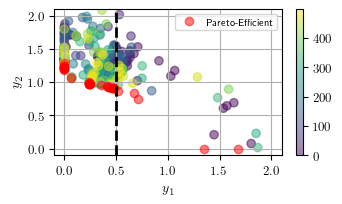

In [21]:
success, failure = filter_failed_objectives(results)

plt.figure(figsize=figsize)
plt.scatter(
    -success[~success["pareto_efficient"]]["objective_0"],
    -success[~success["pareto_efficient"]]["objective_1"],
    marker="o",
    # color="blue",
    c=success[~success["pareto_efficient"]]["job_id"],
    alpha=0.5,
    # label="Non Pareto-Efficient",
)
plt.plot(
    -success[success["pareto_efficient"]]["objective_0"],
    -success[success["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.5,
    label="Pareto-Efficient",
)

plt.axvline(0.5, linewidth=2, color="black", linestyle="--")
plt.colorbar()
plt.grid()
plt.legend(loc="upper right")
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.xlim(0-0.1, 2+0.1)
plt.ylim(0-0.1, 2+0.1)
plt.tight_layout()
# plt.savefig("dtlz2_pf_2d_with_penalty.png")
# plt.savefig("dtlz2_pf_2d.png")
plt.show()

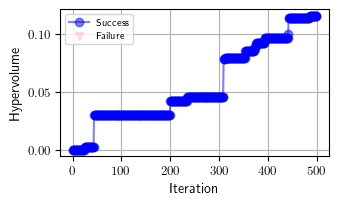

In [8]:
pe = metrics.PerformanceEvaluator()
hv = []
obj = success[["objective_0", "objective_1"]].values
for i in range(len(success)):
    hv_i = pe.hypervolume(obj[: i + 1])
    hv.append(hv_i)

plt.figure(figsize=figsize)
plt.plot(success.index.values, hv, marker="o", color="blue", alpha=0.5, label="Success")
plt.scatter(failure.index.values, np.zeros((len(failure),)), marker="v", alpha=0.1, color="red", label="Failure")
plt.xlabel("Iteration")
plt.ylabel("Hypervolume")
plt.legend()
plt.grid()
plt.show()

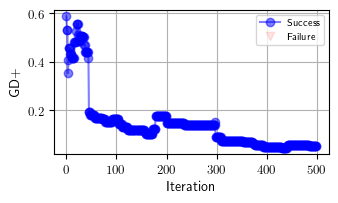

In [9]:
pe = metrics.PerformanceEvaluator()
gd = []
obj = success[["objective_0", "objective_1"]].values
for i in range(len(success)):
    gd_i = pe.gdPlus(obj[: i + 1])
    gd.append(gd_i)

plt.figure(figsize=figsize)
plt.plot(success.index.values, gd, marker="o", color="blue", alpha=0.5, label="Success")
plt.scatter(failure.index.values, np.zeros((len(failure),)), marker="v", alpha=0.1, color="red", label="Failure")
plt.xlabel("Iteration")
plt.ylabel("GD+")
plt.legend()
plt.grid()
plt.show()

In [10]:
from deephyper_benchmark.search import MPIDistributedOptuna

search = MPIDistributedOptuna(
    hpo.problem,
    hpo.run,
    n_objectives=n_objectives,
    sampler="NSGAII",
    moo_lower_bounds=[-0.5, None],
    verbose=1,
)
results_nsgaii = search.search(max_evals=500)

/Users/romainegele/miniforge3/envs/dh-3.11-2310/lib/python3.11/site-packages/optuna/samplers/nsgaii/_sampler.py:162: ExperimentalWarning: The constraints_func option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-19 14:05:35,381] A new study created in memory with name: no-name-8488d074-5d03-4229-929f-a39b0be0448f
[I 2024-02-19 14:05:35,419] Trial 0 finished with values: [-1.5906888889183506, -0.05887223794772286] and parameters: {'x0': 0.023550885578381475, 'x1': 0.07723277938907847, 'x2': 0.968003541276095, 'x3': 0.6547097408970628, 'x4': 0.6753299723822298, 'x5': 0.24921445265291187, 'x6': 0.6803425765070015, 'x7': 0.29041472815876224}. 
[I 2024-02-19 14:05:35,422] Trial 1 finished with values: [-1.6625822942621273, -0.7184051094797748] and parameters: {'x0': 0.25965854005743494, 'x1': 0.28380852786004185, 'x2': 0.884517341946446, 'x3': 0.3170376992377101, 'x4': 0.18166214144840653, 'x5': 0.016842889650575343, 'x6': 0.171013727251507,

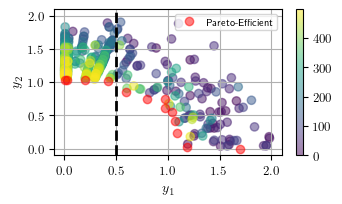

In [15]:
success, failure = filter_failed_objectives(results_nsgaii)

plt.figure(figsize=figsize)
plt.scatter(
    -success[~success["pareto_efficient"]]["objective_0"],
    -success[~success["pareto_efficient"]]["objective_1"],
    marker="o",
    # color="blue",
    c=success[~success["pareto_efficient"]]["job_id"],
    alpha=0.5,
    # label="Non Pareto-Efficient",
)
plt.plot(
    -success[success["pareto_efficient"]]["objective_0"],
    -success[success["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.5,
    label="Pareto-Efficient",
)

plt.axvline(0.5, linewidth=2, color="black", linestyle="--")
plt.colorbar()
plt.grid()
plt.legend(loc="upper right")
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.xlim(0-0.1, 2+0.1)
plt.ylim(0-0.1, 2+0.1)
plt.tight_layout()
# plt.savefig("dtlz2_pf_2d_with_penalty.png")
# plt.savefig("dtlz2_pf_2d.png")
plt.show()

In [12]:
from deephyper_benchmark.search import MPIDistributedOptuna

search = MPIDistributedOptuna(
    hpo.problem,
    hpo.run,
    n_objectives=n_objectives,
    sampler="TPE",
    moo_lower_bounds=[-0.5, None],
    verbose=1,
)
results_tpe = search.search(max_evals=500)

/Users/romainegele/miniforge3/envs/dh-3.11-2310/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:321: ExperimentalWarning: The ``constraints_func`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-19 14:05:37,957] A new study created in memory with name: no-name-aa4722f2-3447-4eaa-bf7d-ced455eb95c5
[I 2024-02-19 14:05:37,958] Trial 0 finished with values: [-0.4329837251799716, -1.207102640829502] and parameters: {'x0': 0.780747307464736, 'x1': 0.4625503712980099, 'x2': 0.7015956798047023, 'x3': 0.8284799293940655, 'x4': 0.32022664678668733, 'x5': 0.26893108144708877, 'x6': 0.49317299740668175, 'x7': 0.7161209906591328}. 
[I 2024-02-19 14:05:37,964] Trial 1 finished with values: [-1.7509154975747216, -0.2901752618248773] and parameters: {'x0': 0.1045552385477655, 'x1': 0.09631092577009459, 'x2': 0.14087081961965053, 'x3': 0.025013931866513572, 'x4': 0.17079562593350528, 'x5': 0.3220546810711389, 'x6': 0.17096155511087718,

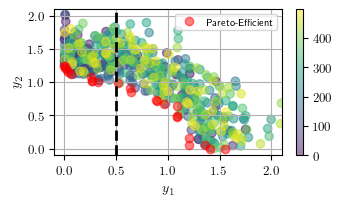

In [16]:
success, failure = filter_failed_objectives(results_tpe)

plt.figure(figsize=figsize)
plt.scatter(
    -success[~success["pareto_efficient"]]["objective_0"],
    -success[~success["pareto_efficient"]]["objective_1"],
    marker="o",
    # color="blue",
    c=success[~success["pareto_efficient"]]["job_id"],
    alpha=0.5,
    # label="Non Pareto-Efficient",
)
plt.plot(
    -success[success["pareto_efficient"]]["objective_0"],
    -success[success["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.5,
    label="Pareto-Efficient",
)

plt.axvline(0.5, linewidth=2, color="black", linestyle="--")
plt.colorbar()
plt.grid()
plt.legend(loc="upper right")
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.xlim(0-0.1, 2+0.1)
plt.ylim(0-0.1, 2+0.1)
plt.tight_layout()
# plt.savefig("dtlz2_pf_2d_with_penalty.png")
# plt.savefig("dtlz2_pf_2d.png")
plt.show()

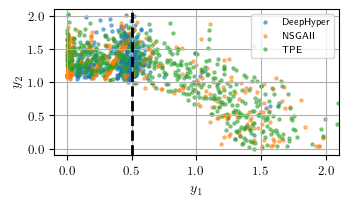

In [25]:
data = {
    "DeepHyper": results,
    "NSGAII": results_nsgaii,
    "TPE": results_tpe,
}


plt.figure(figsize=figsize)

for label, df in data.items():

    success, failure = filter_failed_objectives(df)

    plt.scatter(
        -success[~success["pareto_efficient"]]["objective_0"],
        -success[~success["pareto_efficient"]]["objective_1"],
        marker="o",
        s=5,
        # color="blue",
        # c=success[~success["pareto_efficient"]]["job_id"],
        alpha=0.5,
        label=label,
        # label="Non Pareto-Efficient",
    )
    # plt.plot(
    #         -success[success["pareto_efficient"]]["objective_0"],
    #         -success[success["pareto_efficient"]]["objective_1"],
    #         "o",
    #         # color="red",
    #         alpha=0.5,
    #         label=f"PF ({label})",
    # )

plt.axvline(0.5, linewidth=2, color="black", linestyle="--")
# plt.colorbar()
plt.grid()
plt.legend(loc="upper right")
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.xlim(0-0.1, 2+0.1)
plt.ylim(0-0.1, 2+0.1)
plt.tight_layout()
# plt.savefig("dtlz2_pf_2d_with_penalty.png")
# plt.savefig("dtlz2_pf_2d.png")
plt.show()